# Explore model performances

This document presents an overview of the results from a variety of model outputs, including further modelling chip probabilities.

There are several aspects of the predictions we'd like to explore and compare across models:

- Overall metrics:
     - [x] [Kappa score](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c): measure of how many chips the model got right, _above_ what it would have got by pure chance
     - [x] Accuracy ([micro-F1](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1): general over-simplified measure of how many chips the model got right
     - [x] Macro-F1 averaged: mean of each class' F1
     - [x] Macro-F1 weighted: weighted mean of each class' F1
- Class-based metrics:
     - [x] Accuracy: proportion of chips the model got right for each class
     - [x] Macro-F1: harmonic mean of precision and recall. Roughly, an overview of how good the model is at predicting each single class
- [x] Confusion matrices: more disaggregated view on predictions. Detailed but not summarising.
- Spatial metrics: compare whether the distribution of predicted labels over space resembles that of the true values
     - [x] Moran's I
     - [x] Joint count statistics
     - [x] Quadrat
     - [x] Ripley's G
     - [x] Ripley's F

In [1]:
import os
import pandas
import geopandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tools_chip_prob_modelling as tools
from copy import deepcopy
from pysal.lib import weights
from pysal.explore import esda

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/opt/conda/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


## Data

Here we load the original chip geometries, the true labels and predictions from each model and merge everything into a single geo-table.

- Geometries and true labels

In [2]:
gl = geopandas.read_parquet(
    '/home/jovyan/data/spatial_signatures/chip_probs/model_outputs/db.pq',
    columns=['label', 'train_all', 'geometry']
)

- Model predictions

Grab all files with model predictions

In [3]:
y_preds_f = [
    i for i in os.listdir(
        '/home/jovyan/data/spatial_signatures/chip_probs/model_outputs/'
    ) if '_y_pred.pq' in i
]
y_preds_f

['logite_baseline_wx_y_pred.pq',
 'RandomForestClassifier_baseline_wx_y_pred.pq',
 'RandomForestClassifier_baseline_y_pred.pq',
 'HistGradientBoostingClassifier_baseline_y_pred.pq',
 'maxprob_baseline_y_pred.pq',
 'HistGradientBoostingClassifier_baseline_wx_y_pred.pq',
 'logite_baseline_y_pred.pq']

Read and store predictions and train/val label

In [4]:
y_preds = pandas.DataFrame(None, index=gl.index)
for f in y_preds_f:
    tab = pandas.read_parquet(
        os.path.join('/home/jovyan/data/spatial_signatures/chip_probs/model_outputs/', f)
    ).set_index(
        'id'
    ).rename(
        columns=lambda s: f.replace('_y_pred.pq', '')+'_'+s
    )
    y_preds = y_preds.join(tab)

Check train/val indices align across models so we can remove them:

In [5]:
vals = [c for c in y_preds.columns if '_Validation' in c]
for i in range(len(vals)-1):
    print((y_preds[vals[i]] != y_preds[vals[i+1]]).sum())

0
0
0
0
0
0


- Single table

In [6]:
db = gl.join(y_preds.drop(columns=vals))
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 64409 entries, 4 to 103043
Data columns (total 10 columns):
 #   Column                                             Non-Null Count  Dtype   
---  ------                                             --------------  -----   
 0   label                                              64409 non-null  category
 1   train_all                                          64409 non-null  bool    
 2   geometry                                           64409 non-null  geometry
 3   logite_baseline_wx_y_pred                          64409 non-null  object  
 4   RandomForestClassifier_baseline_wx_y_pred          64409 non-null  object  
 5   RandomForestClassifier_baseline_y_pred             64409 non-null  object  
 6   HistGradientBoostingClassifier_baseline_y_pred     64409 non-null  object  
 7   maxprob_baseline_y_pred                            64409 non-null  object  
 8   HistGradientBoostingClassifier_baseline_wx_y_pred  64409 non-null  

## Metrics

- Set intuitive order of models

In [7]:
model_names = [
    'maxprob_baseline_y_pred',
    'logite_baseline_y_pred',
    'logite_baseline_wx_y_pred',
    'RandomForestClassifier_baseline_y_pred',
    'RandomForestClassifier_baseline_wx_y_pred',
    'HistGradientBoostingClassifier_baseline_y_pred',
    'HistGradientBoostingClassifier_baseline_wx_y_pred'
]
model_names_short = [
    'maxprob_baseline',
    'logite',
    'logite_wx',
    'RF',
    'RF_wx',
    'HBGB',
    'HBGB_wx'
]

- Calculate all metrics by model

In [8]:
metrics = {}
train = db.query('train_all')
val = db.query('~train_all')
for model in model_names:
    meta = tools.build_perf(
        train['label'],
        train[model],
        val['label'],
        val[model],
        tools.class_names
    )
    metrics[model] = deepcopy(meta)

### Global

#### Single scores

In [9]:
global_scores = []
for model in metrics:
    global_scores.append(pandas.Series(
        {i.replace('perf_', '').replace('_val', ''): metrics[model][i] for i in [
            'perf_kappa_val', 
            'perf_model_accuracy_val', 
            'perf_macro_f1_avg_val',
            'perf_macro_f1_w_val'
        ]},
        name=model
    ))
global_scores = pandas.concat(
    global_scores, axis=1
)[
    model_names
].rename(
    columns=lambda s: s.replace('_y_pred', '')
).T
global_scores

,kappa,model_accuracy,macro_f1_avg,macro_f1_w
maxprob_baseline,0.082029,0.240624,0.152201,0.257502
logite_baseline,0.156026,0.418220,0.148086,0.403382
logite_baseline_wx,0.188568,0.426946,0.163392,0.421285
RandomForestClassifier_baseline,0.170341,0.484825,0.167571,0.455233
RandomForestClassifier_baseline_wx,0.262610,0.530728,0.259750,0.505413
HistGradientBoostingClassifier_baseline,0.182966,0.490841,0.209516,0.465232
HistGradientBoostingClassifier_baseline_wx,0.238086,0.503143,0.231285,0.491264


#### Confusion matrices

Standard version with counts of occurrences as values (left panels) and row standardised (right panels):

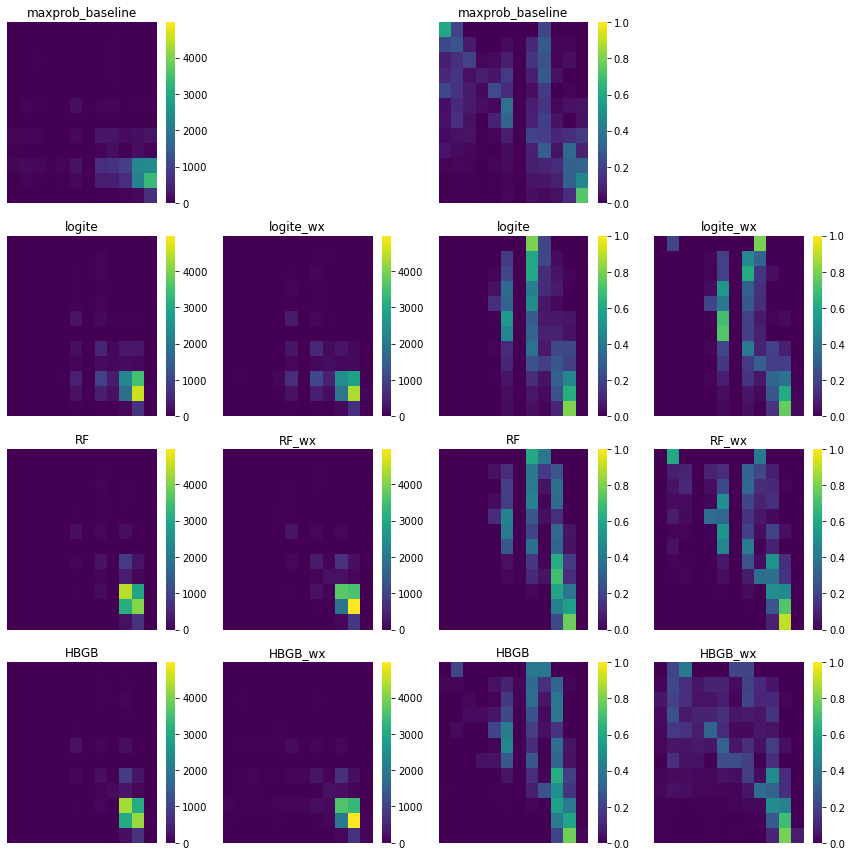

In [10]:
f, axs = plt.subplots(4, 4, figsize=(12, 12))
model_loc = [
    (0, 0), # Maxprob
    (1, 0), # Logite
    (1, 1), # Logite Wx
    (2, 0), # RF
    (2, 1), # RF Wx
    (3, 0), # HGBD
    (3, 1)  # HGBD Wx
]
                    # Raw counts #
maxcount = max([np.array(metrics[model]['perf_confusion_val']).max()])
for i, model in enumerate(model_names):
    ax = tools.build_cm_plot(
        metrics[model]['perf_confusion_val'], 
        maxcount=maxcount,
        ax=axs[model_loc[i]]
    )
    ax.set_title(model_names_short[i])
axs[0, 1].set_axis_off()
                    # Std #
for i, model in enumerate(model_names):
    xy = model_loc[i]
    ax = tools.build_cm_plot(
        metrics[model]['perf_confusion_val'], 
        maxcount=maxcount,
        std=True,
        ax=axs[xy[0], xy[1]+2]
    )
    ax.set_title(model_names_short[i])
axs[0, 3].set_axis_off()
plt.tight_layout()

### Class-based

#### Accuracy

In [11]:
wca = []
for i, model in enumerate(model_names):
    wca.append(pandas.Series(
        metrics[model]['perf_within_class_accuracy_val'],
        metrics[model]['meta_class_names'],
        name=model_names_short[i]
    ))
wca = pandas.concat(
    wca, axis=1
)[model_names_short].T
wca

,urbanity,dense_urban_neighbourhoods,dense_residential_neighbourhoods,connected_residential_neighbourhoods,gridded_residential_quarters,accessible_suburbia,disconnected_suburbia,open_sprawl,warehouse_park_land,urban_buffer,countryside_agriculture,wild_countryside
maxprob_baseline,0.6,0.263889,0.190476,0.082192,0.223529,0.370526,0.000000,0.195699,0.293907,0.120669,0.303030,0.732816
logite,0.0,0.000000,0.000000,0.000000,0.129412,0.528421,0.000000,0.371326,0.184588,0.300146,0.632074,0.005543
logite_wx,0.0,0.000000,0.000000,0.000000,0.200000,0.698947,0.000000,0.409319,0.297491,0.320324,0.602740,0.025499
RF,0.0,0.000000,0.000000,0.000000,0.117647,0.406316,0.000000,0.156272,0.050179,0.587946,0.562889,0.000000
RF_wx,0.0,0.083333,0.114286,0.000000,0.352941,0.526316,0.000000,0.253047,0.363799,0.488384,0.727411,0.003326
HBGB,0.0,0.013889,0.019048,0.027397,0.200000,0.456842,0.000000,0.128315,0.250896,0.571618,0.578525,0.013304
HBGB_wx,0.0,0.222222,0.133333,0.095890,0.317647,0.309474,0.227273,0.177061,0.354839,0.474977,0.687976,0.080931


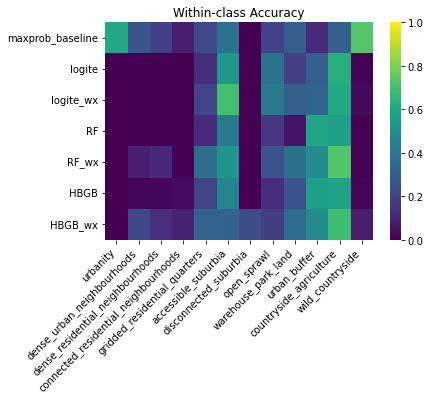

In [12]:
h = sns.heatmap(wca, vmin=0, vmax=1, cmap='viridis')
h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
h.set_title('Within-class Accuracy');

#### Macro F1

In [13]:
f1 = []
for i, model in enumerate(model_names):
    f1.append(pandas.Series(
        metrics[model]['perf_f1_val'],
        metrics[model]['meta_class_names'],
        name=model_names_short[i]
    ))
f1 = pandas.concat(
    f1, axis=1
)[model_names_short].T
f1

,urbanity,dense_urban_neighbourhoods,dense_residential_neighbourhoods,connected_residential_neighbourhoods,gridded_residential_quarters,accessible_suburbia,disconnected_suburbia,open_sprawl,warehouse_park_land,urban_buffer,countryside_agriculture,wild_countryside
maxprob_baseline,0.304762,0.078431,0.358752,0.098765,0.085202,0.000000,0.168889,0.193823,0.195253,0.026316,0.143044,0.173173
logite,0.288009,0.000000,0.555819,0.000000,0.000000,0.000000,0.128655,0.274583,0.372212,0.000000,0.147248,0.010504
logite_wx,0.304029,0.000000,0.568372,0.000000,0.000000,0.000000,0.145923,0.299974,0.389539,0.000000,0.208805,0.044061
RF,0.456805,0.000000,0.533333,0.000000,0.000000,0.000000,0.196078,0.210120,0.527011,0.000000,0.087500,0.000000
RF_wx,0.514403,0.000000,0.613705,0.167832,0.102564,0.000000,0.437956,0.317732,0.516315,0.000000,0.439870,0.006623
HBGB,0.490950,0.052632,0.537680,0.036697,0.025641,0.000000,0.276423,0.190223,0.523844,0.000000,0.354430,0.025668
HBGB_wx,0.371212,0.064815,0.601901,0.108527,0.114695,0.047847,0.189474,0.249874,0.505653,0.000000,0.380769,0.140655


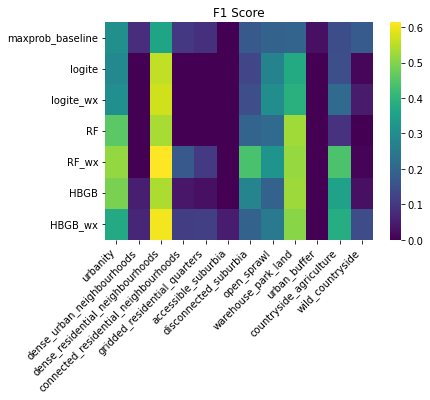

In [14]:
h = sns.heatmap(f1, cmap='viridis')
h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
h.set_title('F1 Score');

### Spatial

The goal in this section is to capture how well a set of predictions reproduces the spatial pattern of the original labels. Our first step for this is to consider the labels for a given class. We take those and calculate measures of spatial concentration, either by considering lattice data or a point pattern. In the former case, we compute measures of degree of clustering that treat our data as both continuous (i.e., probability of class occurrence) and discrete. For the latter, we treat instances of a class as a point pattern that is distribtuted across the geography of interest. We then characterise this pattern spatially with a series of explicitly spatial metrics, and calculate those also for the set of predictions from each model we run. Since both the scores for the labels and the predictions is based on the same set of potential locations (i.e. the underlying set of places where a chip can take 1 or 0), the two can be compared directly. Our metrics of interest are thus the difference between the value of a given spatial statistic for the labels, and that for a set of predictions. Smaller quantities will represent greater affinity between the spatial structure of the original labels and that of our predictions. We operationalise this using the validation set.

What we are going to try to do is characterise the degree of clustering of the predictions for each class. For the set of original labels, these are the maps:

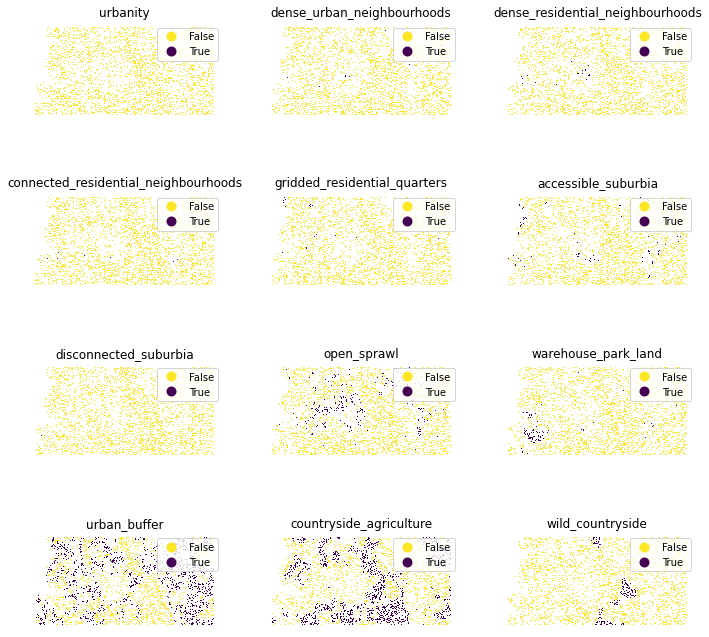

In [90]:
f, axs = plt.subplots(4, 3, figsize=(12, 12))
axs = axs.flatten()
for i, c in enumerate(
    metrics['maxprob_baseline_y_pred']['meta_class_names']
):
    ax = axs[i]
    sp_db.assign(v=sp_db['label'] == c).plot(
        'v', categorical=True, legend=True, cmap='viridis_r', edgecolor='none', ax=ax
    )
    ax.set_title(c)
    ax.set_axis_off()

We start with only the validation set, as that is the pattern we are interested in characterising.

In [15]:
sp_db = db.query(
    'train_all == False'
)

#### Spatial structure (`w` and `coords`)

For lattice metrics, we conceptualise space in a topological way, for which we build a spatial weights matrix. We work with two different types of topology: a distance band and nearest neighbors.

For the distance band, we ensure every polygon is linked to at least one neighbor by calculating the minimum band we need to apply:

In [16]:
min_thr = weights.min_threshold_distance(
    np.array([sp_db.centroid.x, sp_db.centroid.y]).T
)
min_thr

2437.0473938764508

We then build the weights matrix based on that distance:

In [17]:
w_thr = weights.DistanceBand.from_dataframe(sp_db, min_thr)

This produces a set of cardinalities we can explore with an eye to match similarly with the $k$-nearest neighbors weights later.

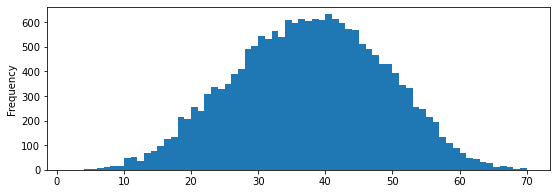

In [18]:
pandas.Series(w_thr.cardinalities).plot.hist(bins=68, figsize=(9, 3));

We then use $k=35$ to build the nearest neighbor weights:

In [19]:
w_knn = weights.KNN.from_dataframe(sp_db, k=35)

The point coordinates of each chip are a more straightforward task. We store them as a `ndarray` as that's how we'll need them later:

In [31]:
xys = sp_db.centroid
xys = np.array([xys.x, xys.y]).T

#### Metric computation

To accelerate computations across different cores, we set it up in Dask:

In [20]:
from dask import bag as dbag
from dask.distributed import Client, LocalCluster

client = Client(LocalCluster(n_workers=8))

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

In [ ]:
client.restart()

And span the computations of all the statistics across different cores:

In [153]:
from importlib import reload
reload(tools);

In [1]:
%%time
wd = {'thr': w_thr, 'knn': w_knn}
tasks = [(
    #     y         w    xys       Name
    sp_db[model], wd, xys, model
) for model in model_names+['label']]

sp_metrics = pandas.concat(dbag.from_sequence(tasks).map(
        tools.spatial_perf
    ).compute())

NameError: name 'w_thr' is not defined

In [158]:
sp_metrics.query('(model=="label") & (metric=="jc_thr")')

,signature,metric,value,model
4,urban_buffer,jc_thr,109045.0,label
11,countryside_agriculture,jc_thr,135527.0,label
18,dense_urban_neighbourhoods,jc_thr,244.0,label
25,open_sprawl,jc_thr,9375.0,label
32,gridded_residential_quarters,jc_thr,366.0,label
39,accessible_suburbia,jc_thr,2163.0,label
46,warehouse_park_land,jc_thr,7677.0,label
53,connected_residential_neighbourhoods,jc_thr,144.0,label
60,dense_residential_neighbourhoods,jc_thr,257.0,label
67,disconnected_suburbia,jc_thr,15.0,label


To do:

- [x] Find out why there are `NaN` values in the table
- [ ] Calculate (weighted) average across classes for overall score
- [x] Move `Moran` computation to a `dask.bag`
- [ ] Update graphics and narrative

#### Lattice-based metrics

##### Moran's I

Now we want to compute Moran's I for each class present in a set of predictions, for which we write the following method:

Now we can calculate measures of distance between each model and the labels:

In [104]:
moran_dists = {}
for model in model_names:
    for w in ['knn', 'thr']:
        moran_dists[f'{model}_{w}'] = (
            morans.loc[f'label_{w}', :] - morans.loc[f'{model}_{w}', :]
        )
moran_dists = pandas.DataFrame(moran_dists)

To visualise which models get closer to the original labels, we focus on each class separately as there is a lot of variation in distance across classes but we really are focused on variation across models _within_ each class. We operationalise this by dividing the scores of a giving class by its average.

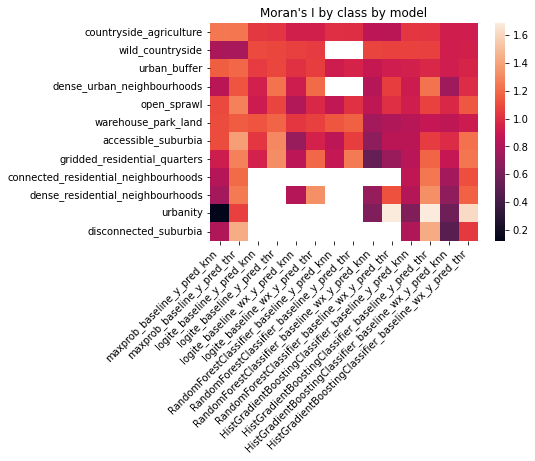

In [112]:
h = sns.heatmap(
    moran_dists.div(moran_dists.mean(axis=1), axis=0)
)
h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
h.set_title("Moran's I by class by model");

**IMPORANT** - Note there are some `NaN` values in the table, these correspond to instances where a model does _not_ predict any chip in a given class.

##### Joint counts

Here we look at [joint counts](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#binary-case-join-counts) and, specifically, focus on the proportion of pairs of a given class that are neighbors.

In [178]:
tst = tools.spatial_perf((sp_db['label'], w_knn, None))

In [179]:
tst

(                                         moran       jcs
 urban_buffer                          0.650926  104942.5
 countryside_agriculture               0.761201  109258.0
 dense_urban_neighbourhoods            0.281699     358.0
 open_sprawl                           0.464526   12172.0
 gridded_residential_quarters          0.293207     440.0
 accessible_suburbia                   0.303767    2649.5
 warehouse_park_land                   0.718528    7098.5
 connected_residential_neighbourhoods  0.153006     199.0
 dense_residential_neighbourhoods      0.222241     414.5
 disconnected_suburbia                 0.037901      15.0
 urbanity                              0.045493       4.0
 wild_countryside                      0.832364   13276.5,
 None)

#### Point pattern metrics